In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("online_retail.csv")
df["Revenue"] = df["Quantity"] * df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [2]:
print(f'Before: {df.shape}')
df.drop_duplicates(inplace=True)
print(f'After: {df.shape}')

Before: (541909, 9)
After: (536641, 9)


In [3]:
df_missingval = df.isna().sum().to_frame().rename(columns={0: 'n_row_missing'})
df_missingval['missing_proportion'] = df_missingval['n_row_missing'] / df.shape[0]
df_missingval.round(3)

,n_row_missing,missing_proportion
InvoiceNo,0,0.000
StockCode,0,0.000
Description,1454,0.003
Quantity,0,0.000
InvoiceDate,0,0.000
UnitPrice,0,0.000
CustomerID,135037,0.252
Country,0,0.000
Revenue,0,0.000


In [4]:
#Only dropping the Customer ID missing values because its essential. If I remove the missing Descriptions
# I will lose more data
df = df.dropna(subset=["CustomerID"])

In [5]:
#Editing columns
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")] #Remove cancelled orders
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

In [6]:
#Feature Engineering
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['YearMonth'] = df['YearMonth'].astype(str) #Convert to string as SQLite doesn't support Period type
df['Revenue'] = df['Quantity'] * df['UnitPrice'] #Create revenue column

In [7]:
print("New Shape:", df.shape)
df.head()

New Shape: (392692, 12)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,2010-12


In [8]:
df.to_csv("clean_retail.csv", index=False)

## SQL Database

In [9]:
import sqlite3
conn = sqlite3.connect("retail.db")
df.to_sql("transactions", conn, if_exists="replace", index=False)

392692

## SQL

In [10]:
#Total revenue
query = """
SELECT SUM(Revenue) AS total_revenue
FROM transactions
"""

pd.read_sql(query, conn)

,total_revenue
0,8.887209e+06


In [11]:
#Total orders
query = """
SELECT COUNT(DISTINCT InvoiceNo) AS total_orders
FROM transactions
"""
pd.read_sql(query, conn)

,total_orders
0,18532


In [12]:
#Total different customers
query = """
SELECT COUNT(DISTINCT CustomerID) AS total_customers
FROM transactions
"""
pd.read_sql(query, conn)

,total_customers
0,4338


In [13]:
#Monthly Revenue
query = """
SELECT
    strftime('%Y-%m', InvoiceDate) AS month,
    SUM(Revenue) AS monthly_revenue
FROM transactions
GROUP BY month
ORDER BY month
"""
monthly_df = pd.read_sql(query, conn)
monthly_df.head()

,month,monthly_revenue
0,2010-12,1087613.170
1,2011-01,568101.310
2,2011-02,446084.920
3,2011-03,594081.760
4,2011-04,468374.331


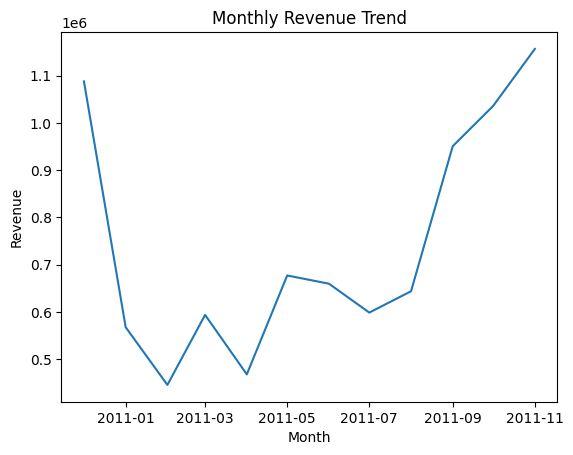

In [14]:
import matplotlib.pyplot as plt

monthly_df['month'] = pd.to_datetime(monthly_df['month'])

plt.plot(monthly_df['month'], monthly_df['monthly_revenue'])
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

The monthly revenue experienced a significant fall in the beginning of 2011, but maintained an uptrend throughout the whole year.

In [15]:
monthly_df['growth_rate'] = monthly_df['monthly_revenue'].pct_change()

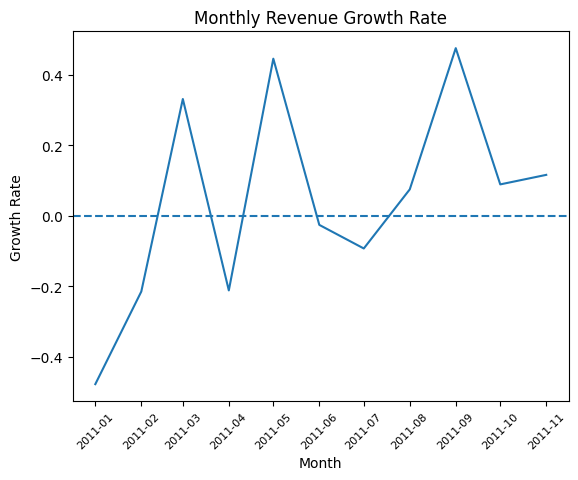

In [16]:
plt.plot(monthly_df['month'], monthly_df['growth_rate'])
plt.axhline(0, linestyle='--')  # zero growth reference line
plt.title("Monthly Revenue Growth Rate")
plt.xlabel("Month")
plt.ylabel("Growth Rate")
plt.xticks(rotation=45, fontsize=8)
plt.show()

Monthly revenue growth fluctuates between the zero growth line, despite the general upward trend.

In [17]:
query = """
SELECT Country, SUM(Revenue) AS total_revenue
FROM transactions
GROUP BY Country
ORDER BY total_revenue DESC
LIMIT 10
"""
country_df = pd.read_sql(query, conn)
country_df

,Country,total_revenue
0,United Kingdom,7.285025e+06
1,Netherlands,2.854463e+05
2,EIRE,2.652625e+05
3,Germany,2.286784e+05
4,France,2.089343e+05
5,Australia,1.384538e+05
6,Spain,6.155856e+04
7,Switzerland,5.644395e+04
8,Belgium,4.119634e+04
9,Sweden,3.836783e+04


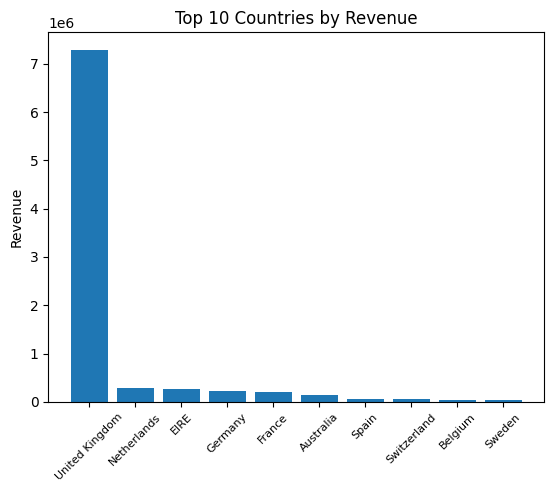

In [18]:
plt.bar(country_df['Country'], country_df['total_revenue'])
plt.title("Top 10 Countries by Revenue")
plt.ylabel("Revenue")
plt.xticks(rotation=45, fontsize=8)
plt.show()

he United Kingdom made up for the majority of total revenue, indicating strong purchasing power.

In [19]:
query = """
SELECT CustomerID, SUM(Revenue) AS total_spent
FROM transactions
GROUP BY CustomerID
ORDER BY total_spent DESC
LIMIT 10
"""
top_customers = pd.read_sql(query, conn)
top_customers

,CustomerID,total_spent
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194390.79
3,16446.0,168472.50
4,14911.0,143711.17
5,12415.0,124914.53
6,14156.0,117210.08
7,17511.0,91062.38
8,16029.0,80850.84
9,12346.0,77183.60


In [20]:
query = """
SELECT SUM(Revenue) AS total_revenue
FROM transactions
"""
total_revenue = pd.read_sql(query, conn)
total_rev = total_revenue.iloc[0,0]
top10_rev = top_customers['total_spent'].sum()

share = top10_rev / total_rev
print(share)

0.17301936168481047


The top 10 customers account for approximately 17% of total revenue, suggesting moderate customer concentration.

In [21]:
#Customer Spending
query = """
SELECT CustomerID, SUM(Revenue) AS total_spent
FROM transactions
GROUP BY CustomerID
"""
customer_spending = pd.read_sql(query, conn)

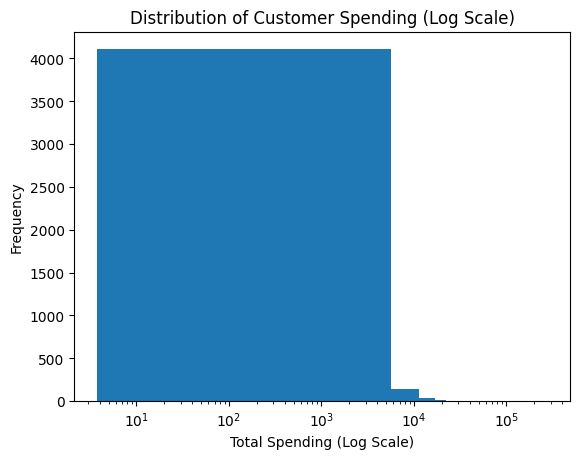

In [22]:
plt.hist(customer_spending['total_spent'], bins=50)
plt.xscale('log')
plt.title("Distribution of Customer Spending (Log Scale)")
plt.xlabel("Total Spending (Log Scale)")
plt.ylabel("Frequency")
plt.show()

Customer spending distribution is heavily right-skewed, showing that most customers are low-to-moderate spenders.

In [23]:
query = """
SELECT AVG(order_total) AS avg_order_value
FROM (
    SELECT InvoiceNo, SUM(Revenue) AS order_total
    FROM transactions
    GROUP BY InvoiceNo
)
"""
pd.read_sql(query, conn)

,avg_order_value
0,479.56016


Average order value stays relatively stable across the dataset.